In [4]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from tika import parser
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import pickle
from wordcloud import WordCloud



nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords', 'vader_lexicon'])

[nltk_data] Downloading package punkt to /Users/jairneto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jairneto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def get_text_from_html(url, tags_to_ignore=["script", "style"]):
    """Extract the text from a webpage

    Parameters
    ----------
    url: String
        The url
    tags_to_ignore: List
        List with the tags to skip when getting the text

    Returns
    -------
    String
        A string file with the text from the webpage
    """
    text = ''
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features="html.parser")
        for script in soup(tags_to_ignore):
            script.extract()    # rip it out

        # get text
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
    except:
        print(f'Could not open the url {url}')
    
    return text

In [6]:
def get_text_from_pdf(path):
    """Extract the text from a pdf

    Parameters
    ----------
    path: String
        Path to a pdf file

    Returns
    -------
    String
        A string file with the text from the pdf file
    """
    text = ''
    try:
        raw = parser.from_file(path)
        text = raw['content']
    except:
        print(f'Could not open the path {path}')

    return text

In [7]:
def get_letters_corpus_dict(letters_pdf_path, init_year=1977, end_year=2020):
    """Build the dict where the keys are the years and the values are
    the text from the Warren Buffet letters

    Parameters
    ----------
    letters_pdf_path: String
        Path to the directory containing the pdf letters
    init_year: int
        The initial year to start getting the letters
    end_year: int
        The finial year to start getting the letters

    Returns
    -------
    Dictionary
        Dict where the keys are the years and the values are
    the text from the Warren Buffet letters
    """
    if init_year < 1977 or end_year > 2020:
        print('The range supported is between 1977 and 2020')
        return {}

    letters_dict = dict()
    letters_years = [year for year in range(init_year, end_year + 1)]
    for year in letters_years:
        if year >= 2000:
            filename = f'{year}ltr.pdf'
            path = Path(letters_pdf_path).joinpath(filename)
            letter_corpus = get_text_from_pdf(str(path))
        else:
            if 1997 < year:
                url = f'https://www.berkshirehathaway.com/letters/{year}htm.html'
            else:
                url = f'https://www.berkshirehathaway.com/letters/{year}.html'
            letter_corpus = get_text_from_html(url)

        letters_dict[year] = letter_corpus
    
    return letters_dict

In [8]:
def draw_heatmap(df, figsize=(15, 6), cmap='YlOrBr', ylabel='', xlabel='', title=''):
    """Draw a heatmap using seaborn

    Parameters
    ----------
    df: Pandas Dataframe
        Pandas Dataframe with the data to show at the heatmap
    figsize: Tuple
        The plot figure size
    cmap: matplotlib colormap name or object, or list of colors, optional
        The mapping from data values to color space. If not provided, the default will depend on whether center is set.
    ylabel: String
        The y label of the plot
    xlabel: String
        The x label of the plot
    title: String
        The title of the plot
    """
    _, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df, cmap=cmap, annot=False)
    ax.set_ylabel(ylabel, fontsize=15)    
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_title(title, fontsize=20, weight='bold')
    plt.show();

In [9]:
def tokenize(text, freq_words=[]):
    """Tokenize the text

    Parameters
    ----------
    text: String
        The message to be tokenized
    freq_words: List
        List with words that appears frequent at the text

    Returns
    -------
    List
        List with the clean tokens
    """
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    tokens = [w for w in tokens if w not in frequent_words_list]

    lemmatizer = WordNetLemmatizer()

    clean_tokens_list = []
    for tok in tokens:
        lemmatizer_tok = lemmatizer.lemmatize(tok).strip()
        clean_tokens_list.append(lemmatizer_tok)

    return clean_tokens_list

In [5]:
letters_dict = get_letters_corpus_dict('/Users/jairneto/Downloads/')

Could not open the url https://www.berkshirehathaway.com/letters/1982.html


2021-04-15 19:48:28,510 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.
2021-04-15 19:48:48,967 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2000ltr.pdf


2021-04-15 19:48:50,800 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2001ltr.pdf


2021-04-15 19:48:51,307 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2002ltr.pdf


2021-04-15 19:48:51,871 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2003ltr.pdf


2021-04-15 19:48:52,356 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2004ltr.pdf


2021-04-15 19:48:52,845 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2005ltr.pdf


2021-04-15 19:48:53,328 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2006ltr.pdf


2021-04-15 19:48:53,792 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2007ltr.pdf


2021-04-15 19:48:54,393 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2008ltr.pdf


2021-04-15 19:48:54,995 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2009ltr.pdf


2021-04-15 19:48:55,723 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2010ltr.pdf


2021-04-15 19:48:56,259 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2011ltr.pdf


2021-04-15 19:48:56,917 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2012ltr.pdf


2021-04-15 19:48:57,864 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2013ltr.pdf


2021-04-15 19:48:58,669 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2014ltr.pdf


2021-04-15 19:48:59,459 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2015ltr.pdf


2021-04-15 19:49:00,182 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2016ltr.pdf


2021-04-15 19:49:00,879 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2017ltr.pdf


2021-04-15 19:49:01,632 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.md5.


Could not open the path /Users/jairneto/Downloads/2018ltr.pdf


2021-04-15 19:49:02,704 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.
2021-04-15 19:49:02,908 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/r8/s5vf_2n90klf6dnc5mf17v5m0000gn/T/tika-server.jar.


Could not open the path /Users/jairneto/Downloads/2019ltr.pdf
Could not open the path /Users/jairneto/Downloads/2020ltr.pdf


In [126]:
# Write the dict to a pickle
with open('letters_dict.pickle', 'wb') as handle:
    pickle.dump(letters_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# Read the dict from a pickle
with open('letters_dict.pickle', 'rb') as handle:
    letters_dict = pickle.load(handle)

In [41]:
frequent_words_list = ['year', 'business', 'berkshire', 'million', 'company', 'u',
                       'billion', 'tax', 'investment', 'share', 'last', 'value',
                       'would', 'many', 'operation', 'market', 'one', 'large', 'p',
                       'make', 'asset', 'also', 'see', 'even', 'well', 'two', 'made',
                       'pre', 'return', 'cost', 'capital', 'may', 'price', 'per', 'first',
                       'annual', 'though', 'however', 'time',
                       'manager', 'money', 'dollar', 'meeting',
                       'interest', 'great', 'group', 'come', 'far',
                       'long', 'worth', 'net', 'report', 'industry', 'put',
                       'contract', 'must', 'yearend', 'day', 'major', 'real', 'since',
                       'let', 'need', 'record', 'good', 'country', 'america', 'period',
                       'average', 'increased', 'home', 'run', 'way',
                       'world', 'second', 'four', 'product', 'largest', 'certain',
                       'financial', 'three',
                       'ago', 'almost', 'american',
                       'amount', 'area', 'b',
                       'believe', 'better', 'blue', 'board',
                       'book', 'borrower', 'brown', 'buffett', 'buyer',
                       'c', 'capacity', 'case', 'cash', 'casualty', 'cat', 'category',
                       'change', 'charge', 'chip', 'charlie',
                       'committee', 'common', 'controlled', 'corporate',
                       'corporation', 'could', 'coupon', 'customer', 'debt',
                       'director',
                       'every',
                       'fee', 'figure', 'find', 'five', 'float',
                       'fund', 'g',
                       'general', 'get', 'give', 'goodwill',
                       'h', 'hathaway', 'helper', 'high', 'holding',
                       'hour', 'housing', 'huge', 'important', 'inc', 'income',
                       'intrinsic',
                       'investor', 'k', 'know', 'le', 'like', 'line', 'look',
                       'low', 'management', 'medium', 'merger',
                       'mr', 'much', 'name', 'national', 'never',
                       'new', 'news', 'non', 'number', 'often', 'operating',
                       'others', 'owned', 'owner', 'ownership', 'page', 'paid',
                       'paper', 'past', 'pay', 'payment', 'people',
                       'preferred', 'premium',
                       'purchase', 'question',
                       'rather', 'ratio',
                       'reported', 'reserve', 'result', 'retained',
                       'rule', 'say',
                       'september', 'service', 'shoe',
                       'star', 'state', 'store', 'subsidiary', 'sunday', 'super',
                       'take', 'ten', 'th',
                       'therefore', 'utility', 'volume',
                       'zero']

In [42]:
## Create a document-term matrix with CountVectorizer
df_letters = None
for k in letters_dict:
    count_v = CountVectorizer(tokenizer=tokenize)
    letter_X = count_v.fit_transform([letters_dict[k]]).toarray()
    if df_letters is None:
        df_letters = pd.DataFrame(letter_X, columns=count_v.get_feature_names(), index=[k])
    else:
        df_letters = df_letters.append(pd.DataFrame(letter_X, columns=count_v.get_feature_names(), index=[k]))

In [43]:
df_heat = None
df_filtered = df_letters.T.query(f"index not in {frequent_words_list}")
for col in df_filtered.columns:
    col = int(col)
    x = df_filtered.sort_values(col, ascending=False)[col]
    if df_heat is None:
        df_heat = x.to_frame()
        df_heat.columns = [col]
    else:
        df_heat[col] = x

In [44]:
key_words = ['ceo', 'insurance', 'shareholder', 'gain', 'loss', 'stock', 'bond',
             'acquisition', 'portfolio', 'risk', 'sale',
             'discount', 'opportunity']
df_frequency_heat = df_heat.loc[key_words].fillna(0)

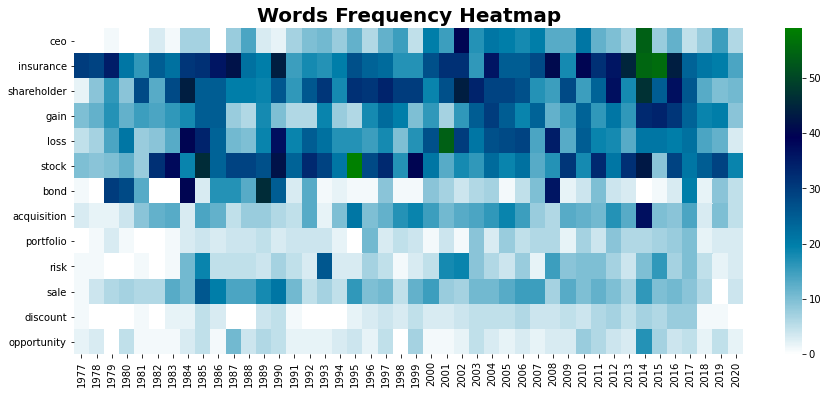

In [45]:
draw_heatmap(df_frequency_heat, cmap='ocean_r', ylabel='', xlabel='', title='Words Frequency Heatmap')

## More frequency analysis

In [8]:
corpus = []
for k in letters_dict:
    corpus.append(letters_dict[k])

In [13]:
tokenized_corpus = []
for text in corpus:
    tokenized_corpus.extend(tokenize(text))

In [14]:
len(tokenized_corpus)

193300

In [19]:
filtered_tokenized_corpus = [w for w in tokenized_corpus if w not in frequent_words_list]

In [22]:
def get_most_frequent_combinatation(tokens, freq=10, num_word_combination=-1):
    """Get a dict with the most frequent onegram, bigram, trigram and quadgrams

    Parameters
    ----------
    text: List
        List with the tokens
    freq: Int
        How many combination to return
    num_word_combination: Int
        1 to onegram
        2 to bigram
        3 to trigram
        4 to quadgrams
        -1 All

    Returns
    -------
    Dict
        Dict with the frequencies
    """
    if num_word_combination < -1 or num_word_combination > 4:
        print(f'The num_word_combination shall be greater than -2 and lesser than 5 the values passes was {num_word_combination}')
        return None
    
    freq_dict = {}
    if num_word_combination == 1 or num_word_combination == -1:
        freq_dist = nltk.FreqDist(tokens)
        freq_dict['FreqDist_onegram'] = freq_dist.most_common(freq)
    
    if num_word_combination == 2 or num_word_combination == -1:
        bigrams = nltk.collocations.BigramCollocationFinder.from_words(tokens)
        freq_dict['FreqDist_bigram'] = bigrams.ngram_fd.most_common(freq)
    
    if num_word_combination == 3 or num_word_combination == -1:
        trigram = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
        freq_dict['FreqDist_trigram'] = trigram.ngram_fd.most_common(freq)
    
    if num_word_combination == 4 or num_word_combination == -1:
        quadgrams = nltk.collocations.QuadgramCollocationFinder.from_words(tokens)
        freq_dict['FreqDist_quadgrams'] = quadgrams.ngram_fd.most_common(freq)
    
    return freq_dict

In [23]:
freq_dict = get_most_frequent_combinatation(tokenized_corpus, 10, -1)

In [24]:
for k in freq_dict:
    print(k)
    print(freq_dict[k])

FreqDist_onegram
[('earnings', 1972), ('year', 1489), ('insurance', 1250), ('u', 1169), ('stock', 1091), ('business', 1070), ('shareholder', 1064), ('company', 885), ('loss', 878), ('gain', 758)]
FreqDist_bigram
[(('balance', 'sheet'), 158), (('underwriting', 'profit'), 141), (('scott', 'fetzer'), 121), (('profit', 'le'), 119), (('coca', 'cola'), 112), (('insurance', 'operation'), 104), (('furniture', 'mart'), 104), (('recent', 'year'), 103), (('le', 'profit'), 103), (('insurance', 'company'), 101)]
FreqDist_trigram
[(('profit', 'le', 'profit'), 103), (('le', 'profit', 'le'), 103), (('nebraska', 'furniture', 'mart'), 95), (('shareholder', 'designated', 'contribution'), 67), (('year', 'index', 'showed'), 38), (('designated', 'contribution', 'program'), 37), (('rate', 'compounded', 'annually'), 36), (('year', 'present', 'took'), 33), (('present', 'took', 'grown'), 32), (('grown', 'rate', 'compounded'), 31)]
FreqDist_quadgrams
[(('profit', 'le', 'profit', 'le'), 103), (('le', 'profit', 'l

In [25]:
freq_dict_filtered = get_most_frequent_combinatation(filtered_tokenized_corpus, 10, -1)

In [26]:
for k in freq_dict_filtered:
    print(k)
    print(freq_dict_filtered[k])

FreqDist_onegram
[('earnings', 1972), ('insurance', 1250), ('stock', 1091), ('shareholder', 1064), ('loss', 878), ('gain', 758), ('profit', 667), ('geico', 602), ('rate', 600), ('term', 509)]
FreqDist_bigram
[(('balance', 'sheet'), 158), (('underwriting', 'profit'), 141), (('scott', 'fetzer'), 121), (('coca', 'cola'), 112), (('profit', 'profit'), 106), (('furniture', 'mart'), 104), (('underwriting', 'loss'), 98), (('nebraska', 'furniture'), 95), (('earnings', 'earnings'), 87), (('short', 'term'), 79)]
FreqDist_trigram
[(('nebraska', 'furniture', 'mart'), 95), (('profit', 'profit', 'profit'), 95), (('shareholder', 'designated', 'contribution'), 67), (('designated', 'contribution', 'program'), 37), (('rate', 'compounded', 'annually'), 36), (('present', 'took', 'grown'), 32), (('grown', 'rate', 'compounded'), 31), (('took', 'grown', 'rate'), 30), (('attachment', 'proxy', 'material'), 29), (('washington', 'post', 'fargo'), 27)]
FreqDist_quadgrams
[(('profit', 'profit', 'profit', 'profit'),

In [ ]:
def drawn_wordcloud(corpus, save_path, figsize=(15, 6)):
    """Get a dict with the most frequent onegram, bigram, trigram and quadgrams

    Parameters
    ----------
    corpus: List
        List with the words
    save_path: String
        Path to the file where the wordcloud will be saved at
    figsize: Tuple
        The figsize
    """
    _, _ = plt.subplots(figsize=figsize)
    combined_text = " ".join(text for text in corpus)
    wordcloud = WordCloud().generate(combined_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(save_path)
    plt.show();
    

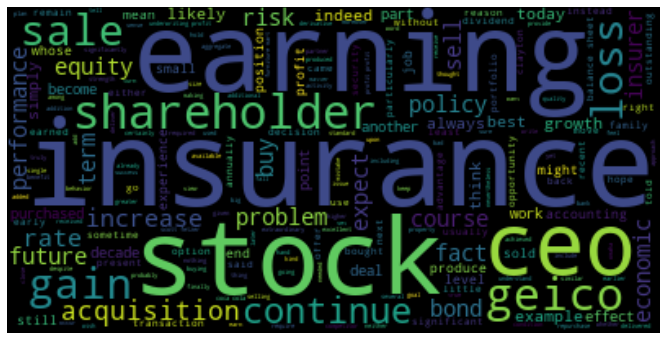

In [39]:
drawn_wordcloud(filtered_tokenized_corpus, 'wordcloud_filtered.png')

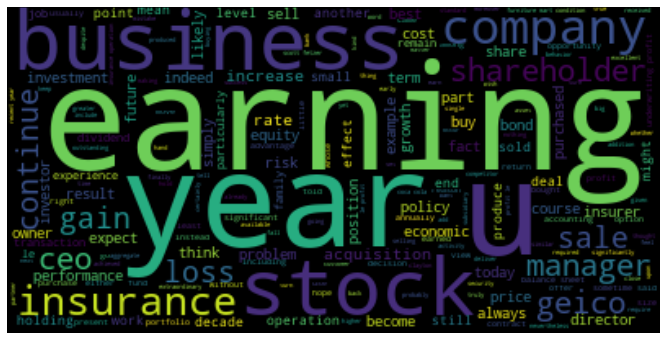

In [38]:
drawn_wordcloud(tokenized_corpus, 'wordcloud_complete.png')

# Sentiment Analysis

In [12]:
def tokenize_sent(text):
    """Tokenize the sentence

    Parameters
    ----------
    text: String
        The text to be tokenized

    Returns
    -------
    List
        List with the tokenized sentences
    """
    sentence_list = nltk.tokenize.sent_tokenize(text)
    tokenized_list = []
    for i, sentence in enumerate(sentence_list):
        sentence_after_regex = re.sub("[^a-z0-9A-Z]", " ", sentence)
        # Remove sentences where there was only numbers
        if len(re.sub("[^a-zA-Z]", "", sentence_after_regex)) > 6:
            tokenized_list.append(sentence_after_regex)
        
    return tokenized_list

In [90]:
def calculate_text_sentiment_using_transform(sentence_list):
    """Calculate the test sentiment using transforms

    Parameters
    ----------
    sentence_list: List
        List with the tokenizes sentences

    Returns
    -------
    Dictonary
        Dict with the cumulative sentiment of all the sentences at the list
    """
    sentiment_dict = {'POSITIVE': 0, 'NEGATIVE': 0}
    classifier = pipeline('sentiment-analysis')
    for sentence in sentence_list:
        sentiment_result = classifier(sentence)
        sentiment_dict[sentiment_result[0]['label']] += sentiment_result[0]['score']
    
    return sentiment_dict

In [14]:
def calculate_text_sia(sentence_list):
    """Calculate the test sentiment using Sentiment Intensity Analyzer

    Parameters
    ----------
    sentence_list: List
        List with the tokenizes sentences

    Returns
    -------
    Dictonary
        Dict with the cumulative sentiment of all the sentences at the list
    """
    sentiment_dict = {'neg': 0, 'neu': 0, 'pos':0, 'compound': 0}
    sia = SentimentIntensityAnalyzer()
    for sentence in sentence_list:
        sentiment_result = sia.polarity_scores(sentence)
        for k in sentiment_result:
            sentiment_dict[k] += sentiment_result[k]
    
    return sentiment_dict

In [18]:
def get_sentiment_analysis_df(letters_dict, calculate_text_sentiment, tokenize_sent, normalized=True):
    """Get the DataFrame with the sentiment of each Warren letter

    Parameters
    ----------
    letters_dict: Dictonary
        Dict with the letters text
    calculate_text_sentiment: function
        Function used to calculate the sentiment of the text
    tokenize_sent: function
        Function to tokenize the text into a list of sentences
    normalized: bool
        If the values of the df will be normalized or not

    Returns
    -------
    Pandas DataFrame
        Pandas DataFrame with the sentiment analysis for each letter
    """
    sentiment_analysis_dict = {}
    for k in letters_dict:
        sentiment_analysis_dict[k] = calculate_text_sentiment(tokenize_sent(letters_dict[k]))
    sentiment_analysis_df = pd.DataFrame(sentiment_analysis_dict)
    if normalized:
        return sentiment_analysis_df / sentiment_analysis_df.sum(axis=0)
    else:
        return sentiment_analysis_df

In [19]:
sia_sentiment_analysis_df = get_sentiment_analysis_df(letters_dict, calculate_text_sia, tokenize_sent)

In [94]:
sentiment_analysis_dict

{1977: {'POSITIVE': 67.96296000480652, 'NEGATIVE': 54.083554565906525},
 1978: {'POSITIVE': 67.05853360891342, 'NEGATIVE': 93.06378763914108},
 1979: {'POSITIVE': 77.01054233312607, 'NEGATIVE': 161.98340386152267},
 1980: {'POSITIVE': 95.56516122817993, 'NEGATIVE': 203.46058571338654},
 1981: {'POSITIVE': 88.16864144802094, 'NEGATIVE': 183.20994251966476},
 1982: {'POSITIVE': 100.29267656803131, 'NEGATIVE': 223.4047194123268},
 1983: {'POSITIVE': 172.9189089536667, 'NEGATIVE': 314.1965189576149},
 1984: {'POSITIVE': 168.90455889701843, 'NEGATIVE': 340.5783559679985},
 1985: {'POSITIVE': 214.13192158937454, 'NEGATIVE': 358.5559770464897},
 1986: {'POSITIVE': 217.72969657182693, 'NEGATIVE': 353.10389721393585},
 1987: {'POSITIVE': 221.43746024370193, 'NEGATIVE': 346.293879032135},
 1988: {'POSITIVE': 194.29901099205017, 'NEGATIVE': 314.9840022325516},
 1989: {'POSITIVE': 215.81600522994995, 'NEGATIVE': 399.1436996459961},
 1990: {'POSITIVE': 230.56103110313416, 'NEGATIVE': 396.5322471261

In [97]:
transformers_sentiment_analysis_df = get_sentiment_analysis_df(letters_dict, calculate_text_sentiment_transform, tokenize_sent)

In [101]:
transformers_sentiment_analysis_df

,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
POSITIVE,0.556861,0.418796,0.322228,0.319588,0.324892,0.309835,0.354985,0.331522,0.373907,0.381424,...,0.497369,0.487432,0.50474,0.461852,0.497629,0.447469,0.478325,0.427582,0.461616,0.527134
NEGATIVE,0.443139,0.581204,0.677772,0.680412,0.675108,0.690165,0.645015,0.668478,0.626093,0.618576,...,0.502631,0.512568,0.49526,0.538148,0.502371,0.552531,0.521675,0.572418,0.538384,0.472866


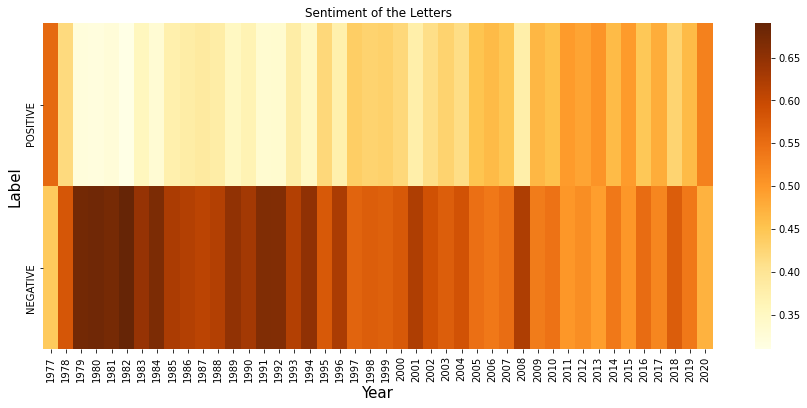

In [100]:
draw_heatmap(transformers_sentiment_analysis_df, title='Sentiment of the Letters using Transformers')

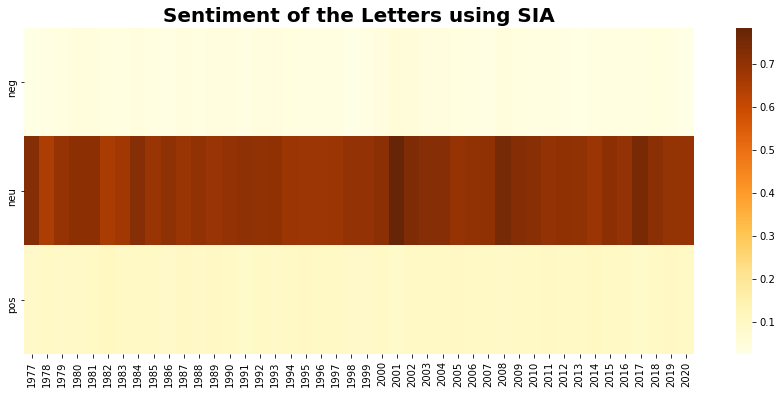

In [39]:
draw_heatmap(sia_sentiment_analysis_df.loc[['neg', 'neu', 'pos']], title='Sentiment of the Letters using SIA')

## QA

In [2]:
nlp = pipeline("question-answering")

In [39]:
def get_answer_using_qa(nlp, question, context):
    """Get answer using a classifier trained with the QA technique

    Parameters
    ----------
    nlp: Pipeline
        Trained QA Pipeline
    question: String
        Question that the model will answer
    context: String
        The Context of the question

    Returns
    -------
    Tuple
        The answer, the score, the start position of the answer at the text and the final
        position of the answer at the text
    """
    sentence_after_regex = re.sub("[^a-z0-9A-Z\,]", " ", context)
    result = nlp(question=question, context=sentence_after_regex)
    return result['answer'], round(result['score'], 4), result['start'], result['end']

In [40]:
answer, result, start, end = get_answer_using_qa(nlp, "What led to a dysfunctional credit market?", sentence_after_regex)
print(f"Answer: '{answer}', score: {result}, start: {start}, end: {end}")

Answer: 'a series of life threatening problems', score: 0.5841, start: 7575, end: 7612


In [31]:
result = nlp(question="What led to a dysfunctional credit market?", context=sentence_after_regex)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")


Answer: 'a series of life threatening problems', score: 0.5841, start: 7575, end: 7612


In [32]:
result = nlp(question="What produced a paralyzing fear that engulfed the country?", context=sentence_after_regex)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")


Answer: 'the credit crisis', score: 0.4479, start: 7942, end: 7959


In [33]:
result = nlp(question="What generated a paralyzing fear that engulfed the country?", context=sentence_after_regex)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'credit crisis', score: 0.4273, start: 7946, end: 7959


In [34]:
result = nlp(question="Who are the managers of MidAmerican?", context=sentence_after_regex)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'Dave Sokol and Greg Abel', score: 0.9798, start: 18182, end: 18206


In [35]:
result = nlp(question="What are upside-down loans?", context=sentence_after_regex)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Answer: 'a house is worth less than its mortgage', score: 0.4057, start: 42184, end: 42223
